In [ ]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [2]:
import numpy as np
import pandas as pd
import umap

from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


np.random.seed(seed=42) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [3]:
X,y = make_classification(n_samples=15000, n_classes=3, weights=[0.5,0.25,0.25], n_features=10,
                          n_informative=5, n_redundant=5, class_sep=0.7, n_clusters_per_class=1,
                          hypercube=True, shuffle=True, random_state=42)

In [4]:
data = pd.DataFrame(X)
labels = pd.Series(y)
# data.hist(figsize=(20,12))

In [34]:
# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, labels, valid_size=0.5)


# original_labels = train_labels.copy()
# train_labels[train_labels > 0] = 1
train_labels.value_counts()

0    3735
2    1883
1    1882
dtype: int64

In [33]:
test_data.shape

(4500, 10)

### Note: The labels used for the split are training and NOT original
> ###  Sublcusters may be imbalanced 

In [35]:
X_train = train_data
y_train = train_labels.copy()
y_train[y_train > 0] = 1

X_valid = test_data
y_valid = test_labels.copy()
y_valid[y_valid > 0] = 1

In [59]:
y_train.value_counts()

1    3765
0    3735
dtype: int64

In [6]:
# X_train, y_train, X_valid, y_valid = split_valid(train_data, train_labels, valid_size=0.5)

In [53]:
def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    
    dnn.add(Dense(units = 10, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 10, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))

    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [54]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=125,
                    min_dist=0)

In [55]:
nn = build_dnn(num_features=train_data.shape[1])
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.527, Acc:0.7742
Prediction Accuracy
751/751 [==============================] - 0s 68us/step
Scores on data set: loss=0.416 accuracy=0.8602
Fold Correct: 646
Running worker: 1
Fold: 1 -> Loss:0.510, Acc:0.8028
Prediction Accuracy
751/751 [==============================] - 0s 11us/step
Scores on data set: loss=0.393 accuracy=0.8735
Fold Correct: 656
Running worker: 2
Fold: 2 -> Loss:0.517, Acc:0.7952
Prediction Accuracy
751/751 [==============================] - 0s 10us/step
Scores on data set: loss=0.413 accuracy=0.8895
Fold Correct: 668
Running worker: 3
Fold: 3 -> Loss:0.515, Acc:0.7945
Prediction Accuracy
751/751 [==============================] - 0s 11us/step
Scores on data set: loss=0.399 accuracy=0.8722
Fold Correct: 655
Running worker: 4
Fold: 4 -> Loss:0.521, Acc:0.7905
Prediction Accuracy
751/751 [==============================] - 0s 12us/step
Scores on data set: loss=0.383 accuracy=0.8748
Fold Correct: 657
Runn

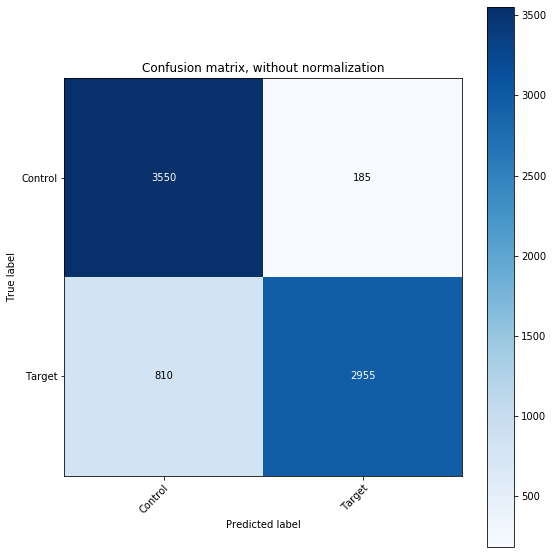

In [56]:
cm = pipeline.train_model(batch_size=20,epochs=50, cross_validation=True, parallel=False, verbose=0)

In [72]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=125,
                    min_dist=0)

pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

_, correct_pred_idxs = pipeline.train_clusterer(plot=False)

Minimum Size:
Clusters                  (122, 122)
Noise                     (122, 122)
Halkidi                   (123, 123)
Halkidi-Filtered Noise    (124, 124)
dtype: object


In [73]:
max(pipeline.clusterer.labels_)+1

2

In [68]:
def plot_clusters(pipeline):
    
    training_lrp = pipeline.training_lrp
    
    # Internally populates self.val_set_lrp
    samples, cluster_labels = pipeline.get_validation_clusters()
    
    val_lrp = pipeline.val_set_lrp
    # pipeline.reducer_pipeline[0].n_neighbors
    embedding_pipeline = Pipeline([
        ("reducer", umap.UMAP(random_state=42,
                        n_components = 3,
                        n_neighbors=15,
                        min_dist=0.1)),
       ("scaler", MinMaxScaler())
    ])
    embedding_pipeline.fit(training_lrp)

    embedding = embedding_pipeline.transform(training_lrp)

    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Training",
        marker=dict(
            size=2,
            color=pipeline.clusterer.labels_,
            colorscale="Rainbow",
            opacity=0.8
        ),
        text=pipeline.clusterer.labels_
    )

    val_3d_embedding = embedding_pipeline.transform(val_lrp)

    val_emb3d = go.Scatter3d(
        x=val_3d_embedding[:,0],
        y=val_3d_embedding[:,1],
        z=val_3d_embedding[:,2],
        name="Validation",
        mode="markers",
        marker=dict(
            size=5,
            color=cluster_labels,
            colorscale='Viridis',
            opacity=0.8,
            showscale=True
        ),
        text = cluster_labels
    )

    layout = go.Layout(
        title="3D LRP Embedding",
        autosize=False,
        width=1200,
        height=1000,
        paper_bgcolor='#F5F5F5',
    #     template="plotly"
    )


    data=[emb3d, val_emb3d]

    fig = go.Figure(data=data, layout=layout)
    # fig.update_layout(template="plotly")  /

    iplot(fig, filename='lrp-3d-scatter.html')

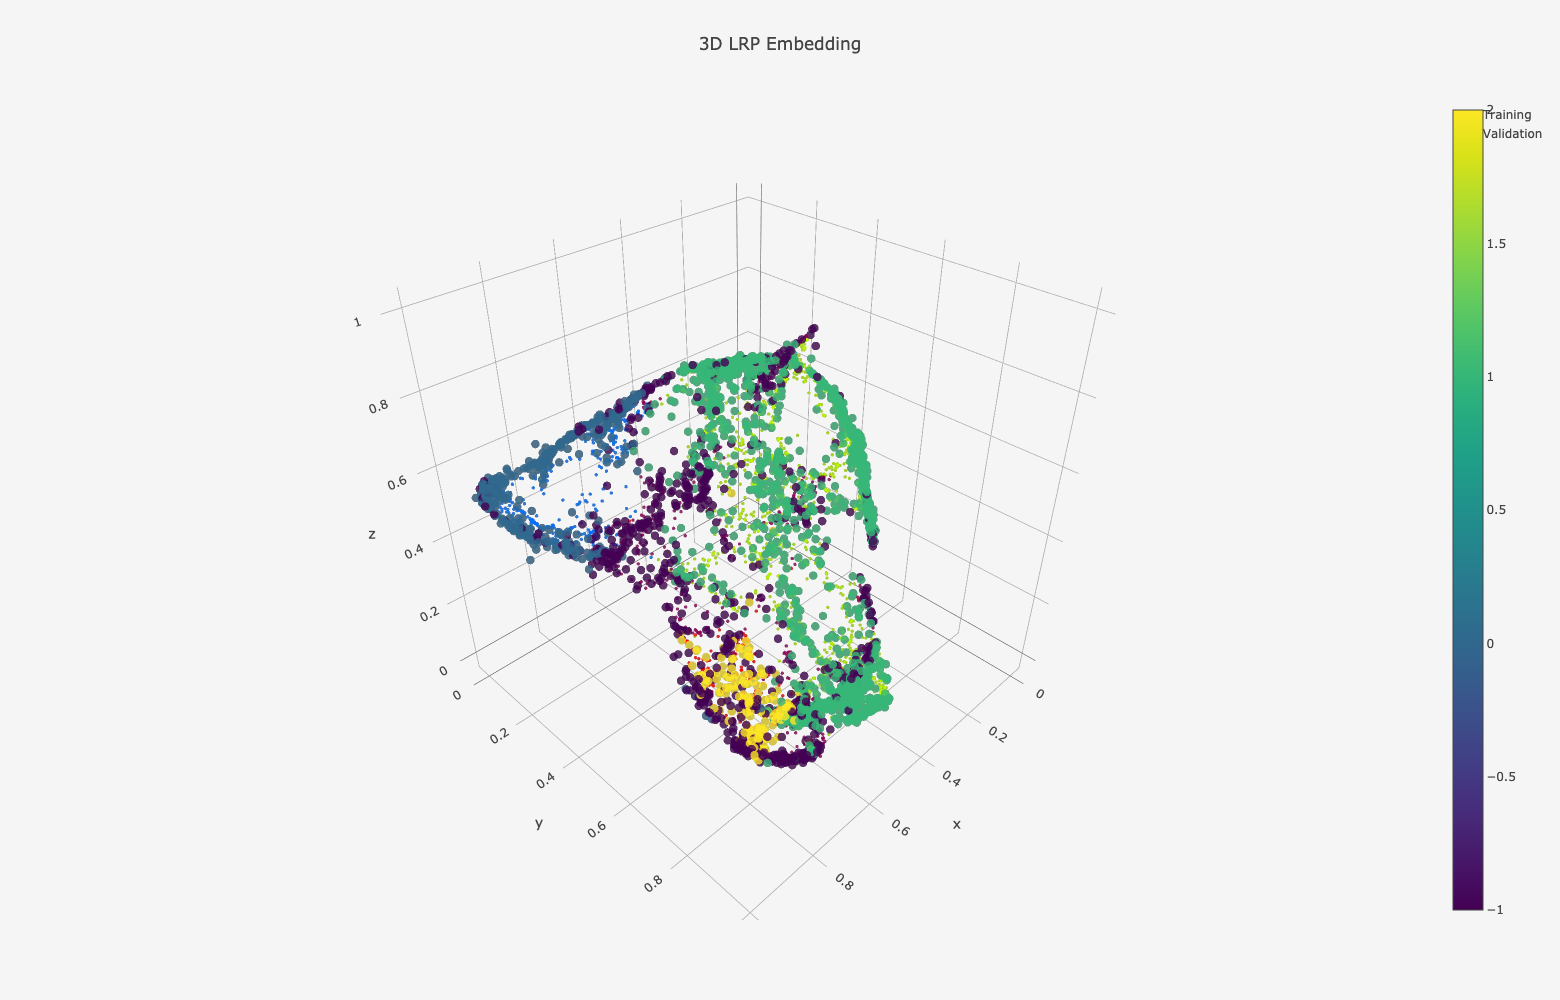

In [69]:
plot_clusters(pipeline)

In [21]:
# Are the actual subclasses extracted?
# test_data, test_labels

In [77]:
test_data.shape

(7500, 10)

In [117]:
# Internally populates self.val_set_lrp
val_samples_target, cluster_labels = pipeline.get_validation_clusters()

In [133]:
best_predictions, best_DNN = pipeline.get_predictions()

# Only consider the samples from the class(es) which are expected to have subclusters
target_class = best_predictions == pipeline.target_class
control_class = best_predictions != pipeline.target_class

val_samples_control = pipeline.val_set.features.values[pipeline.val_pred_mask][control_class]
control_labels = pipeline.val_set.labels.values[pipeline.val_pred_mask][control_class]

original_labels = test_labels[pipeline.val_pred_mask][target_class]

Prediction Accuracy: 0.9199


In [134]:
print("Control:", val_samples_control.shape)
print("Target:", val_samples_target.shape)

Control: (3668, 10)
Target: (3231, 10)


# TODO: Check if subclusters match with original classes

In [135]:
all(pipeline.val_set.labels.index == test_labels.index)

True

In [136]:
pd.Series(cluster_labels).value_counts()

 1    1463
-1     850
 0     734
 2     184
dtype: int64

In [137]:
# clustered_samples = val_samples_target[cluster_labels > -1]
original_labels = original_labels[cluster_labels > -1]
clustered_samples = cluster_labels[cluster_labels > -1]

In [ ]:
clustered_features = val_samples[cluster_labels > -1]

In [140]:
pd.Series(clustered_samples).value_counts()

1    1463
0     734
2     184
dtype: int64

In [139]:
pd.Series(original_labels).value_counts()

2    1228
1    1153
dtype: int64

In [142]:
from sklearn import metrics

labels_true = original_labels
labels_pred = clustered_samples

In [143]:
metrics.adjusted_mutual_info_score(labels_true, labels_pred)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning:

The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.



0.23221108140069888

In [144]:
metrics.adjusted_rand_score(labels_true, labels_pred)

0.21157179929280814

In [145]:
metrics.completeness_score(labels_true, labels_pred) 

0.2325867590100566

In [ ]:
## Plot the LRP

In [ ]:
# # Internally populates self.val_set_lrp
# samples, cluster_labels = pipeline.get_validation_clusters()

# val_lrp = pipeline.val_set_lrp
# # pipeline.reducer_pipeline[0].n_neighbors
# embedding_pipeline = Pipeline([
#     ("reducer", umap.UMAP(random_state=42,
#                     n_components = 3,
#                     n_neighbors=15,
#                     min_dist=0.1)),
#    ("scaler", MinMaxScaler())
# ])
# embedding_pipeline.fit(training_lrp)

# embedding = embedding_pipeline.transform(training_lrp)

#     emb3d = go.Scatter3d(
#         x=embedding[:,0],
#         y=embedding[:,1],
#         z=embedding[:,2],
#         mode="markers",
#         name="Training",
#         marker=dict(
#             size=2,
#             color=pipeline.clusterer.labels_,
#             colorscale="Rainbow",
#             opacity=0.8
#         ),
#         text=pipeline.clusterer.labels_
#     )
